# Ejercicio 2: POS Tagging

## 1. Preprocesado del corpus

Lectura o descarga del corpus

In [1]:
import os
import nltk
from nltk.corpus import cess_esp

CORPUS_FILE = "./corpus.txt"

if not os.path.exists(CORPUS_FILE):
    nltk.download("cess_esp")
    corpus_sentences = cess_esp.tagged_sents()

    outfile = open(CORPUS_FILE, 'w') 
    for sentence in (corpus_sentences):
        str_sent = ''
        for element in sentence:
            str_sent = str_sent + ('~'.join(element) + ' ')
        outfile.write(str_sent + '\n')
    outfile.close()
else:
    infile = open(CORPUS_FILE, 'r')
    corpus_sentences = []
    for sentence in infile:
        corpus_line = []
        for element in sentence.split():
            corpus_line.append(tuple(element.split('~')))
        corpus_sentences.append(corpus_line)
    infile.close()

[nltk_data] Downloading package cess_esp to
[nltk_data]     C:\Users\NachoDíez\AppData\Roaming\nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


Reducción de etiquetas

In [2]:
transformed_corpus = []
for sentence in corpus_sentences:
    new_line = []
    for word, key in sentence:
        if word == "*0*" and key == "sn":
            continue
        elif key[0] == 'v' or key[0] == 'F':
            key = key[:3]
        else:
            key = key[:2]
        new_line.append((word,key))
    transformed_corpus.append(new_line)

División en conjuntos de entrenamiento y test

In [3]:
from sklearn.model_selection import train_test_split
training_corpus, test_corpus = train_test_split(transformed_corpus, train_size=0.9, test_size=0.1)

## 2. Utilidades

### 2.1 Evaluación

10-fold cross validation

In [17]:
from nltk.tag import hmm, tnt
from random import shuffle

def ten_fold_validation(tagger):
    fold_size = int(len(transformed_corpus)/10)
    shuffled_corpus = transformed_corpus.copy()
    shuffle(shuffled_corpus)
    accuracies = []

    for i in range(10):
        folded_test_corpus = shuffled_corpus[i*fold_size:(i+1)*fold_size]
        folded_training_corpus = shuffled_corpus[:i*fold_size] + shuffled_corpus[(i+1)*fold_size:]

        if (tagger == 'hmm'):
            tagger = nltk.HiddenMarkovModelTagger.train(folded_training_corpus)
        elif (tagger == 'tnt'):
            tagger = tnt.TnT()
            tagger.train(folded_training_corpus)
        accuracies.append(tagger.accuracy(folded_test_corpus))
    return accuracies

IC

In [5]:
import numpy as np

def return_ic(precision, n):
    delta = 1.96 * np.sqrt(precision * (1 - precision) / n)
    return delta

### 2.2 Representación

In [6]:
import matplotlib.pyplot as plt

def plot_accuracy(results, ic, model_name):
    x = [i for i in range(10)]
    y = results
    min_y = round(min(y) * 20) / 20
    max_y = round(max(y) * 20) / 20
    plt.axis([-1, 10, max(min_y - 0.1, 0), min(max_y + 0.1, 1)])
    plt.ylabel('Accuracy')
    plt.xlabel('Fold')
    plt.title(f'Ten-fold cross validation - {model_name}')
    plt.plot(x, y, 'ro')
    plt.errorbar(x, y, yerr=ic, linestyle='None')
    filename = f"ten_fold_validation_{model_name}.png"
    plt.show()
    plt.clf()

## 3. HMM

Entrenamiento

In [7]:
tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_corpus)

Precisión del modelo

In [8]:
print("HMM accuracy: %f" % tagger_hmm.accuracy(test_corpus))

HMM accuracy: 0.928805


10-fold cross validation

In [9]:
hmm_fold_accuracies = ten_fold_validation('hmm')
hmm_fold_accuracies_ic = [return_ic(acc, len(transformed_corpus)/10) for acc in hmm_fold_accuracies]
print("HMM 10-fold accuracies: ")
for i, acc in enumerate(hmm_fold_accuracies):
    print("\tFold %d: %f" % (i+1, acc))
    print("\t\tIC: %f - %f" % (acc - hmm_fold_accuracies_ic[i], acc + hmm_fold_accuracies_ic[i]))
print("Mean accuracy: %f" % np.mean(hmm_fold_accuracies))
print("Standard deviation: %f" % np.std(hmm_fold_accuracies))

HMM 10-fold accuracies: 
	Fold 1: 0.927993
		IC: 0.907361 - 0.948626
	Fold 2: 0.973004
		IC: 0.960068 - 0.985940
	Fold 3: 0.974203
		IC: 0.961550 - 0.986857
	Fold 4: 0.971631
		IC: 0.958379 - 0.984883
	Fold 5: 0.973001
		IC: 0.960064 - 0.985938
	Fold 6: 0.974160
		IC: 0.961496 - 0.986823
	Fold 7: 0.973412
		IC: 0.960572 - 0.986253
	Fold 8: 0.972638
		IC: 0.959617 - 0.985659
	Fold 9: 0.971939
		IC: 0.958758 - 0.985121
	Fold 10: 0.973194
		IC: 0.960302 - 0.986086
Mean accuracy: 0.968518
Standard deviation: 0.013531


Representación

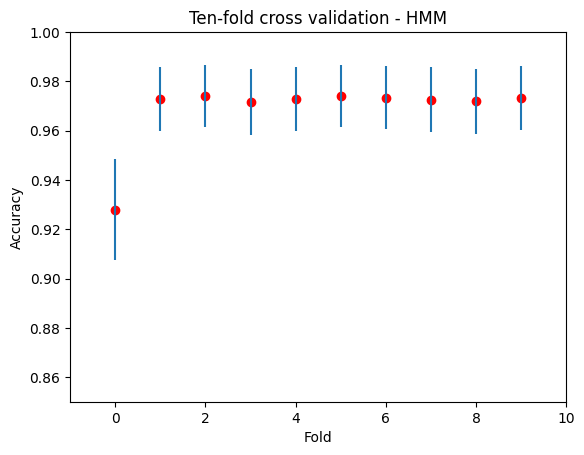

<Figure size 640x480 with 0 Axes>

In [10]:
plot_accuracy(hmm_fold_accuracies, hmm_fold_accuracies_ic, 'HMM')

## 4. TNT

Entrenamiento

In [13]:
tagger_tnt = tnt.TnT()
tagger_tnt.train(training_corpus)

Precisión del modelo

In [14]:
print("TnT accuracy: %f" % tagger_tnt.accuracy(test_corpus))

TnT accuracy: 0.904265


10-fold cross validation

In [18]:
tnt_fold_accuracies = ten_fold_validation('tnt')
tnt_fold_accuracies_ic = [return_ic(acc, len(transformed_corpus)/10) for acc in tnt_fold_accuracies]
print("TnT 10-fold accuracies: ")
for i, acc in enumerate(tnt_fold_accuracies):
    print("\tFold %d: %f" % (i+1, acc))
    print("\t\tIC: %f - %f" % (acc - tnt_fold_accuracies_ic[i], acc + tnt_fold_accuracies_ic[i]))
print("Mean accuracy: %f" % np.mean(tnt_fold_accuracies))
print("Standard deviation: %f" % np.std(tnt_fold_accuracies))

TnT 10-fold accuracies: 
	Fold 1: 0.898635
		IC: 0.874545 - 0.922725
	Fold 2: 0.992614
		IC: 0.985780 - 0.999448
	Fold 3: 0.992408
		IC: 0.985480 - 0.999336
	Fold 4: 0.992891
		IC: 0.986185 - 0.999597
	Fold 5: 0.991262
		IC: 0.983834 - 0.998691
	Fold 6: 0.993370
		IC: 0.986892 - 0.999848
	Fold 7: 0.991998
		IC: 0.984887 - 0.999110
	Fold 8: 0.992255
		IC: 0.985257 - 0.999252
	Fold 9: 0.992368
		IC: 0.985422 - 0.999315
	Fold 10: 0.992753
		IC: 0.985982 - 0.999523
Mean accuracy: 0.983055
Standard deviation: 0.028145


Representación

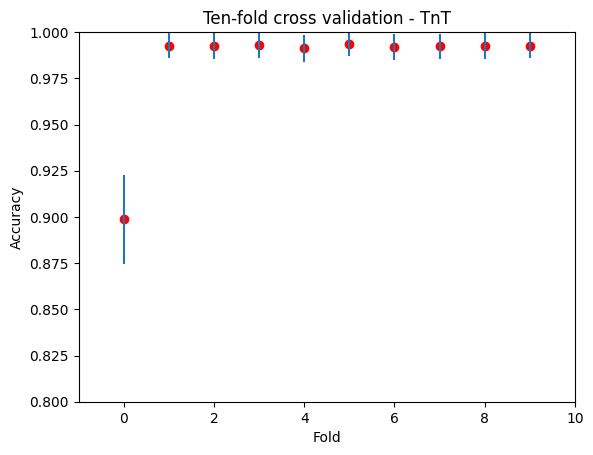

<Figure size 640x480 with 0 Axes>

In [19]:
plot_accuracy(tnt_fold_accuracies, tnt_fold_accuracies_ic, 'TnT')